In [1]:
from data.mnist import MnistDataset
from models.lenet.lenet import LeNet5
from utils.train import *
from utils.quantize import *

import torch
import torch.nn as nn


/usr/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_CLASSES = 10
DEVICE = None
EPOCHS = 5

In [3]:
dataset = MnistDataset(BATCH_SIZE, './data')
model = LeNet5(N_CLASSES)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

22:42:35 --- Epoch: 1	Train loss: 0.6829	Valid loss: 0.3322	Train accuracy: 89.85	Valid accuracy: 90.54
22:43:46 --- Epoch: 2	Train loss: 0.3006	Valid loss: 0.2515	Train accuracy: 92.05	Valid accuracy: 92.70
22:44:58 --- Epoch: 3	Train loss: 0.2316	Valid loss: 0.1928	Train accuracy: 93.77	Valid accuracy: 94.13
22:46:18 --- Epoch: 4	Train loss: 0.1879	Valid loss: 0.1664	Train accuracy: 94.48	Valid accuracy: 94.83
22:47:44 --- Epoch: 5	Train loss: 0.1562	Valid loss: 0.1501	Train accuracy: 95.24	Valid accuracy: 95.27


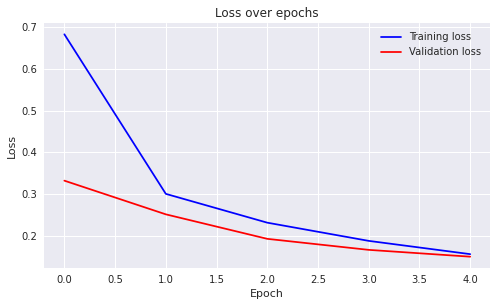

In [4]:
train_net(model, criterion, optimizer, dataset, EPOCHS)

In [5]:
print(model.parameters)

<bound method Module.parameters of LeNet5(
  (quant): QuantStub()
  (dequant): DeQuantStub()
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)>


In [6]:
model.eval()
model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
model = torch.quantization.prepare(model)

for X, _ in dataset.valid_dl:
    model(X)

int8_model = torch.quantization.convert(model, inplace=False)

for name, param in int8_model.named_parameters():
    print(name)
    print(param.data.shape)
    print(param.data)

int8_model.state_dict()

/home/coupekv/.local/lib/python3.10/site-packages/torch/ao/quantization/observer.py:177: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


OrderedDict([('quant.scale', tensor([0.0079])),
             ('quant.zero_point', tensor([0])),
             ('feature_extractor.0.weight',
              tensor([[[[ 0.0033,  0.1512,  0.0427,  0.0855, -0.0427],
                        [ 0.0132,  0.3123,  0.2696,  0.0756,  0.1184],
                        [ 0.1743,  0.3880,  0.3814,  0.4175,  0.2926],
                        [-0.0362,  0.3978,  0.2367,  0.1545,  0.0822],
                        [ 0.1841,  0.2367,  0.2992,  0.2564,  0.2071]]],
              
              
                      [[[-0.0386,  0.1416,  0.0676, -0.1512,  0.0064],
                        [ 0.2349,  0.1834,  0.1738,  0.2542,  0.1384],
                        [ 0.1834,  0.2317,  0.3733,  0.3282,  0.0740],
                        [-0.0097,  0.0354,  0.2703,  0.4087,  0.1673],
                        [ 0.1770, -0.0290,  0.2092, -0.0386,  0.1995]]],
              
              
                      [[[ 0.0296, -0.1867,  0.1778, -0.0415, -0.0593],
               

In [7]:
get_accuracy(int8_model, dataset.valid_dl, 'cpu')

tensor(0.9516)